# Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import statsmodels.api as sm
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller

In [2]:
pd.plotting.register_matplotlib_converters()

In [3]:
mat.rcParams.update({'figure.figsize':(20,15), 'font.size': 14})

# Reading the data

In [4]:
energy_consumption = pd.read_csv('data/PJME_hourly.csv')

# Preprocessing

In [5]:
energy_consumption.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [6]:
energy_consumption.dtypes

Datetime     object
PJME_MW     float64
dtype: object

In [7]:
energy_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
Datetime    145366 non-null object
PJME_MW     145366 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [8]:
energy_consumption['Datetime'] = pd.to_datetime(energy_consumption['Datetime'])

In [9]:
energy_consumption = energy_consumption.set_index('Datetime').resample('H').sum()

In [10]:
energy_consumption.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Freq: H
Data columns (total 1 columns):
PJME_MW    145392 non-null float64
dtypes: float64(1)
memory usage: 2.2 MB


In [11]:
hours_no_consumption = energy_consumption.loc[energy_consumption['PJME_MW'] == 0].copy()

# Exploratory Analysis

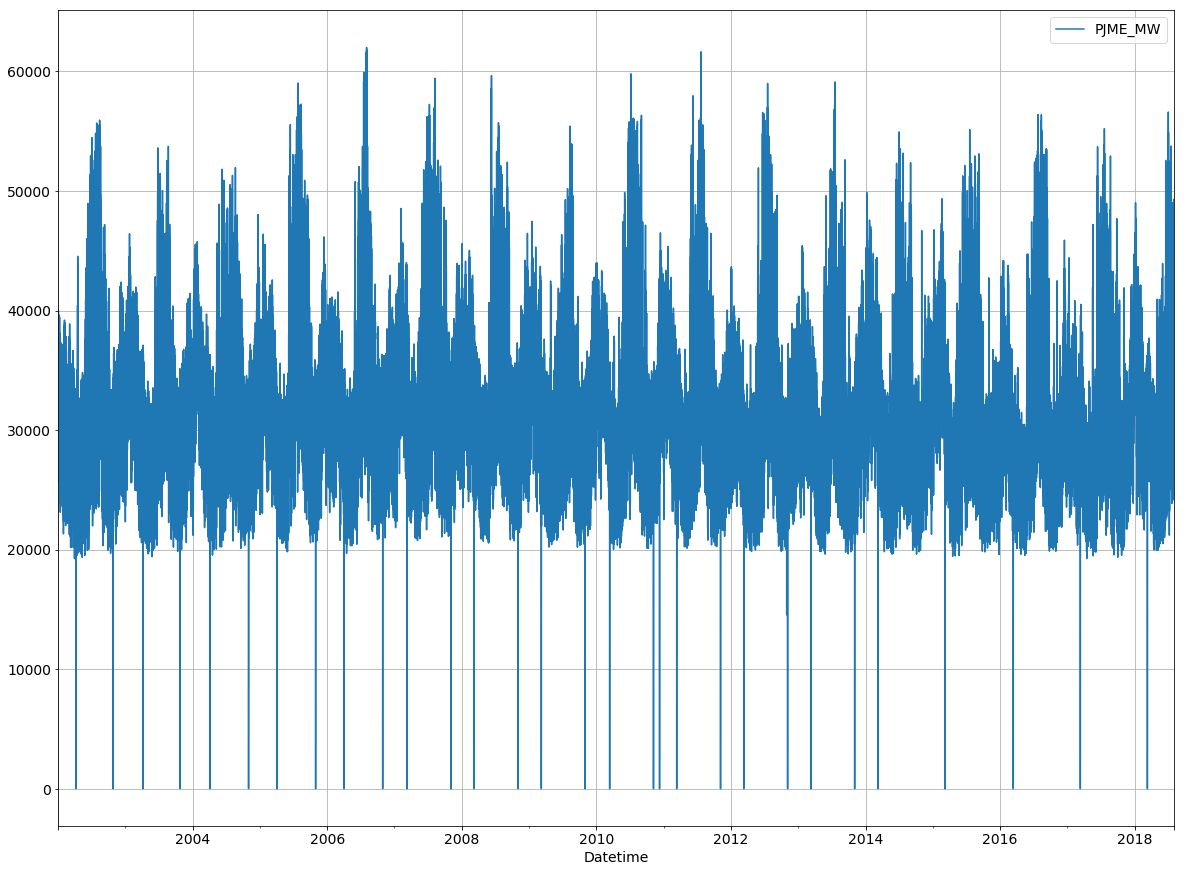

In [12]:
energy_consumption.plot(grid=True)
# plt.yscale('log')
plt.show()

In [13]:
energy_consumption.describe()

,PJME_MW
count,145392.000000
mean,32074.486024
std,6479.660890
min,0.000000
25%,27571.000000
50%,31420.000000
75%,35648.250000
max,62009.000000


- Total energy consumption falls between (0 - 62009) MW
- Averge energy consumption per hour is 32074.5 MW with std of 6479.7

In [14]:
energy_consumption.loc[~energy_consumption.index.isin(hours_no_consumption.index)].describe()

,PJME_MW
count,145362.000000
mean,32081.105598
std,6463.923399
min,14544.000000
25%,27574.000000
50%,31421.000000
75%,35650.750000
max,62009.000000


Removing the hours with no energy consumption data:
- The average energy consumption didn't change alot.
- Minimum recorded energy consumtion is 14544 MW.

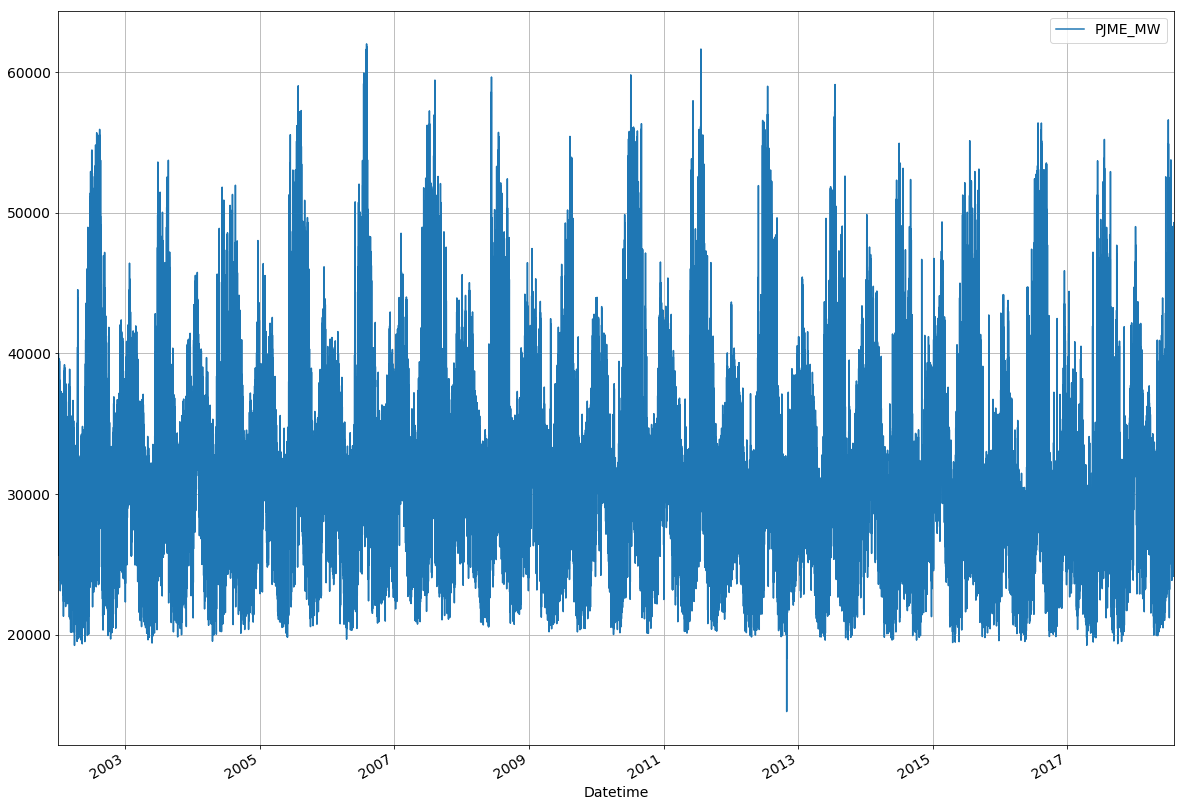

In [15]:
energy_consumption.loc[~energy_consumption.index.isin(hours_no_consumption.index)].plot(grid=True)
# plt.yscale('log')
plt.show()

95% of the energy consumption falls between:

In [16]:
energy_consumption['PJME_MW'].quantile([0.025]).values[0]

21678.0

In [17]:
energy_consumption['PJME_MW'].quantile([0.975]).values[0]

47523.225000000006

In [18]:
energy_consumption.loc[(energy_consumption['PJME_MW'] >= energy_consumption['PJME_MW'].quantile([0.025]).values[0])
                      &
                      (energy_consumption['PJME_MW'] <= energy_consumption['PJME_MW'].quantile([0.975]).values[0])].describe()

,PJME_MW
count,138123.000000
mean,31872.380813
std,5575.156271
min,21678.000000
25%,27801.500000
50%,31420.000000
75%,35363.000000
max,47523.000000


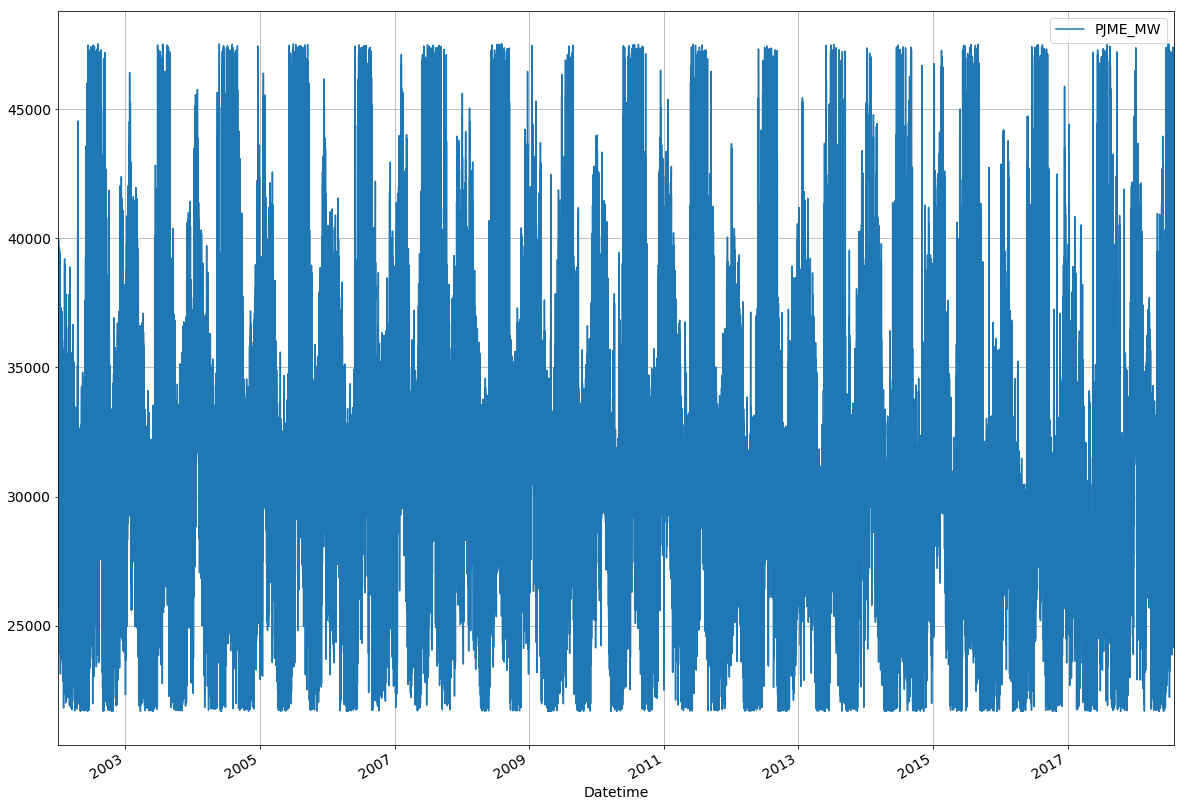

In [19]:
energy_consumption.loc[(energy_consumption['PJME_MW'] >= energy_consumption['PJME_MW'].quantile([0.025]).values[0])
                      &
                      (energy_consumption['PJME_MW'] <= energy_consumption['PJME_MW'].quantile([0.975]).values[0])].plot(grid=True)
plt.show()

In [20]:
energy_consumption.resample('YS').mean().sort_values('PJME_MW',ascending=False).head(1)

,PJME_MW
Datetime,
2007-01-01,33605.794292


In [21]:
energy_consumption.resample('YS').mean().sort_values('PJME_MW',ascending=False).tail(1)

,PJME_MW
Datetime,
2017-01-01,30650.911644


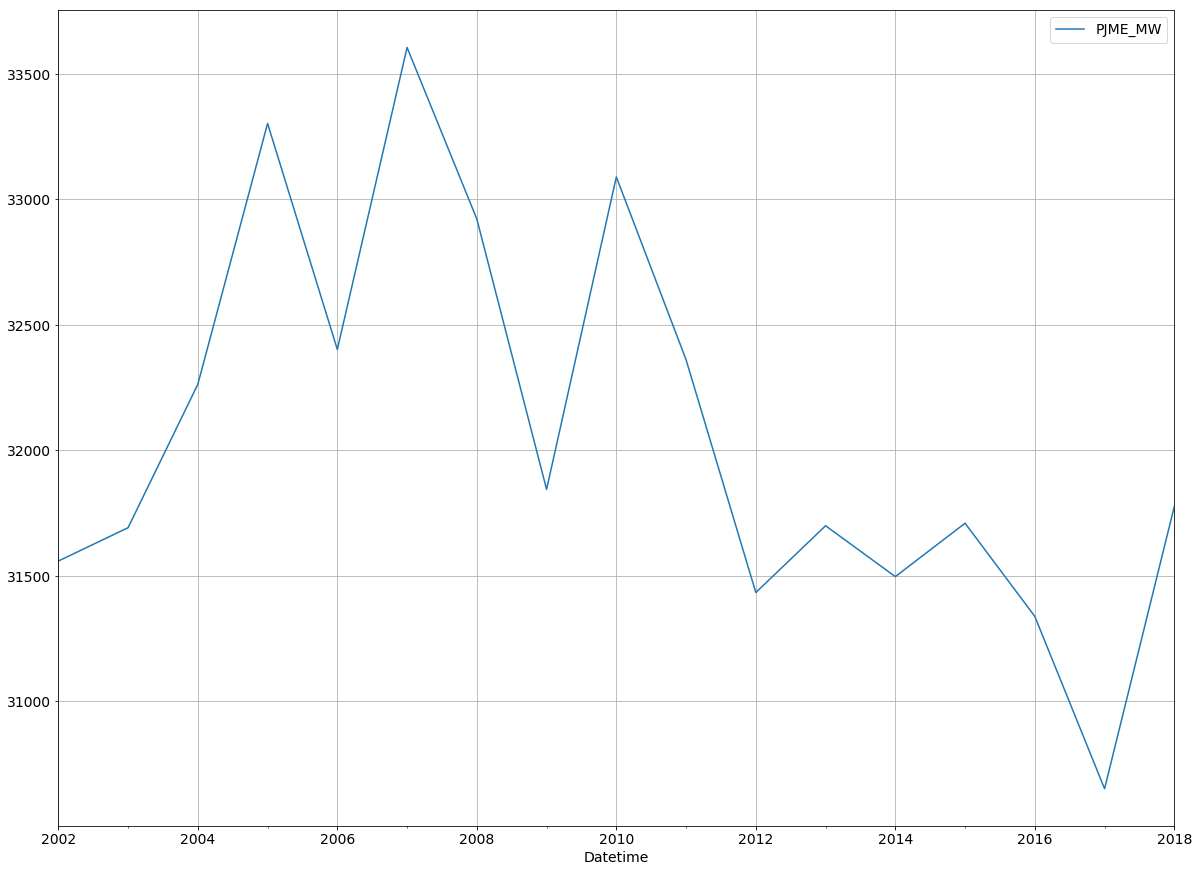

In [22]:
energy_consumption.resample('YS')[['PJME_MW']].mean().plot(grid=True)
plt.show()

- 2007 Had the highest average energy consumption per hour, 2005 follows
- 2017 has the lowest, interesting!

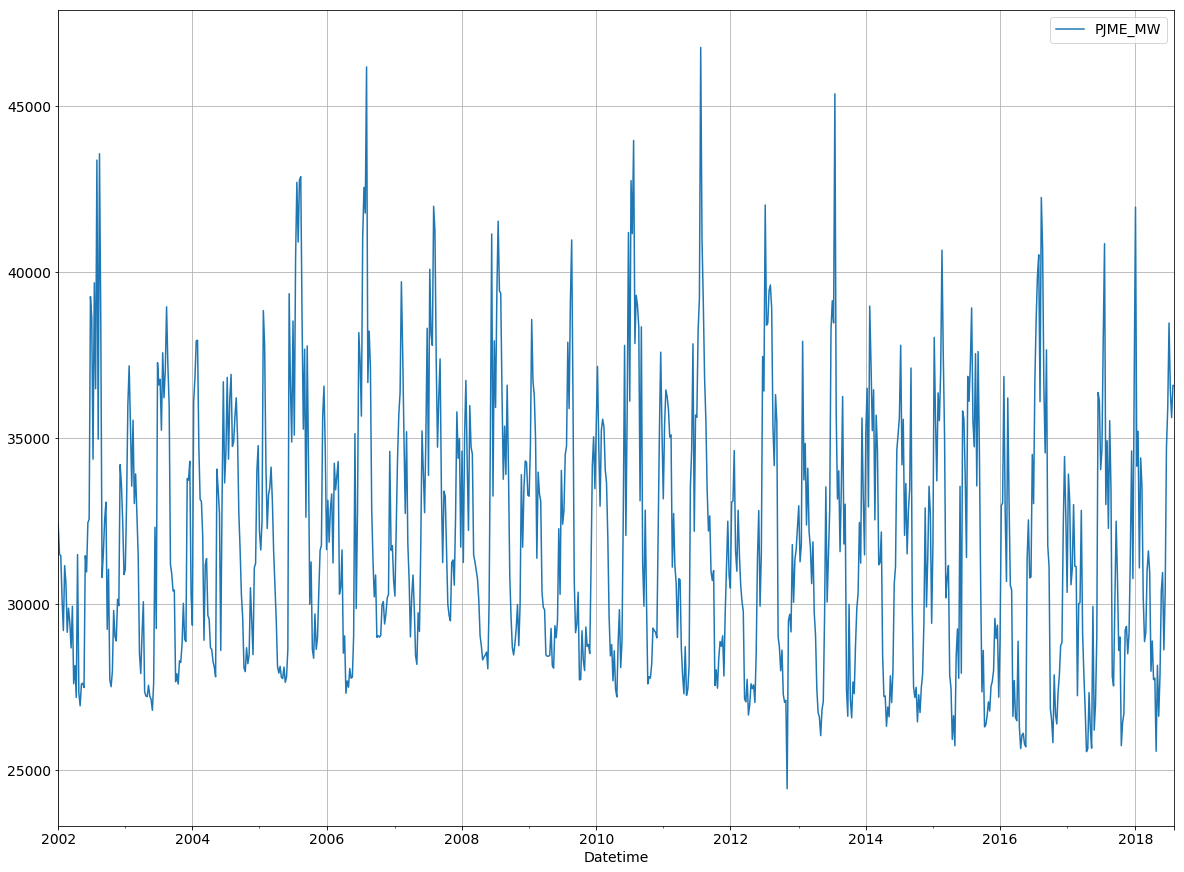

In [23]:
energy_consumption.resample('W').mean().plot(grid=True)
plt.show()

In [24]:
energy_consumption.loc['01-01-2018':].resample('W').mean().sort_values('PJME_MW',ascending=False).head(1)

,PJME_MW
Datetime,
2018-01-07,41951.339286


- first week in Jan 2018 had the highest energy consumption

In [25]:
energy_consumption['Hour'] = energy_consumption.index.hour

In [26]:
max_hour = energy_consumption.loc[energy_consumption.loc['06-01-2018':'07-31-2018'].resample('D')['PJME_MW'].idxmax()].copy()

- The highest energy consumption in 2018 was in 2018-07-03 "Tuesday"

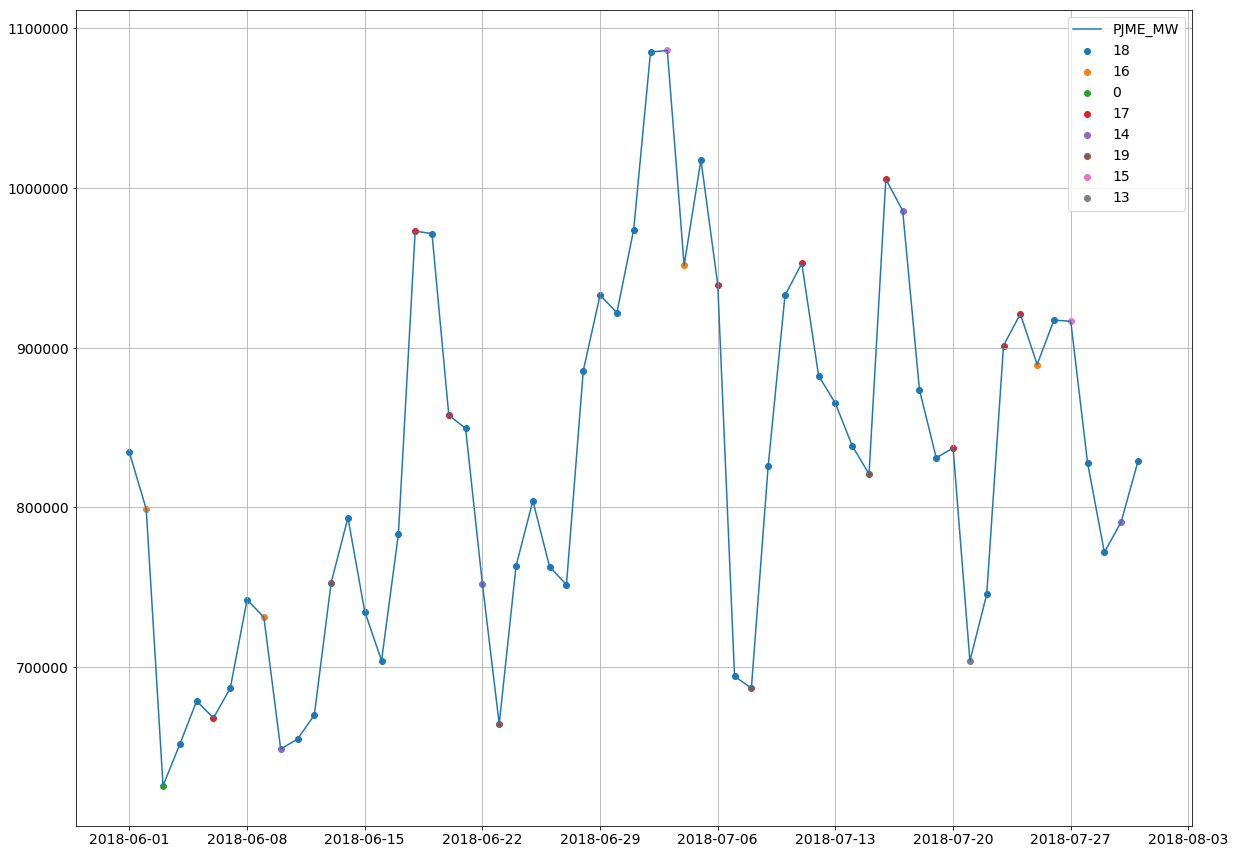

In [27]:
df = energy_consumption.loc['06-01-2018':'07-31-2018'].resample('D')[['PJME_MW']].sum()
_ = plt.plot(df.index, df.PJME_MW)
for H in max_hour['Hour'].unique():
    df = energy_consumption.loc['06-01-2018':'07-31-2018'].resample('D')[['PJME_MW']].sum()
    df = df.loc[max_hour.loc[max_hour['Hour'] == H].index.date].copy()
    _ = plt.scatter( x = df.index, y = df.PJME_MW, label = H)
plt.grid()
plt.legend()
plt.show()

- 6 PM is the hour with the highest consumtion in most of the days for the selected period

In [28]:
dayofweek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
energy_consumption['Day of Week'] = energy_consumption.index.dayofweek
energy_consumption['Day of Week'] = energy_consumption['Day of Week'].apply(lambda x: dayofweek[x])

In [29]:
energy_consumption.loc['01-01-2018':].groupby([energy_consumption.loc['01-01-2018':].index.date,
                                               'Day of Week'])[['PJME_MW']].sum().sort_values('PJME_MW',
                                                                                              ascending=False).head()

,,PJME_MW
,Day of Week,
2018-07-03,Tuesday,1086193.0
2018-07-02,Monday,1085235.0
2018-01-05,Friday,1060747.0
2018-01-06,Saturday,1045578.0
2018-07-05,Thursday,1017657.0


- The highest energy consumption in 2018 was in 2018-07-03 "Tuesday"

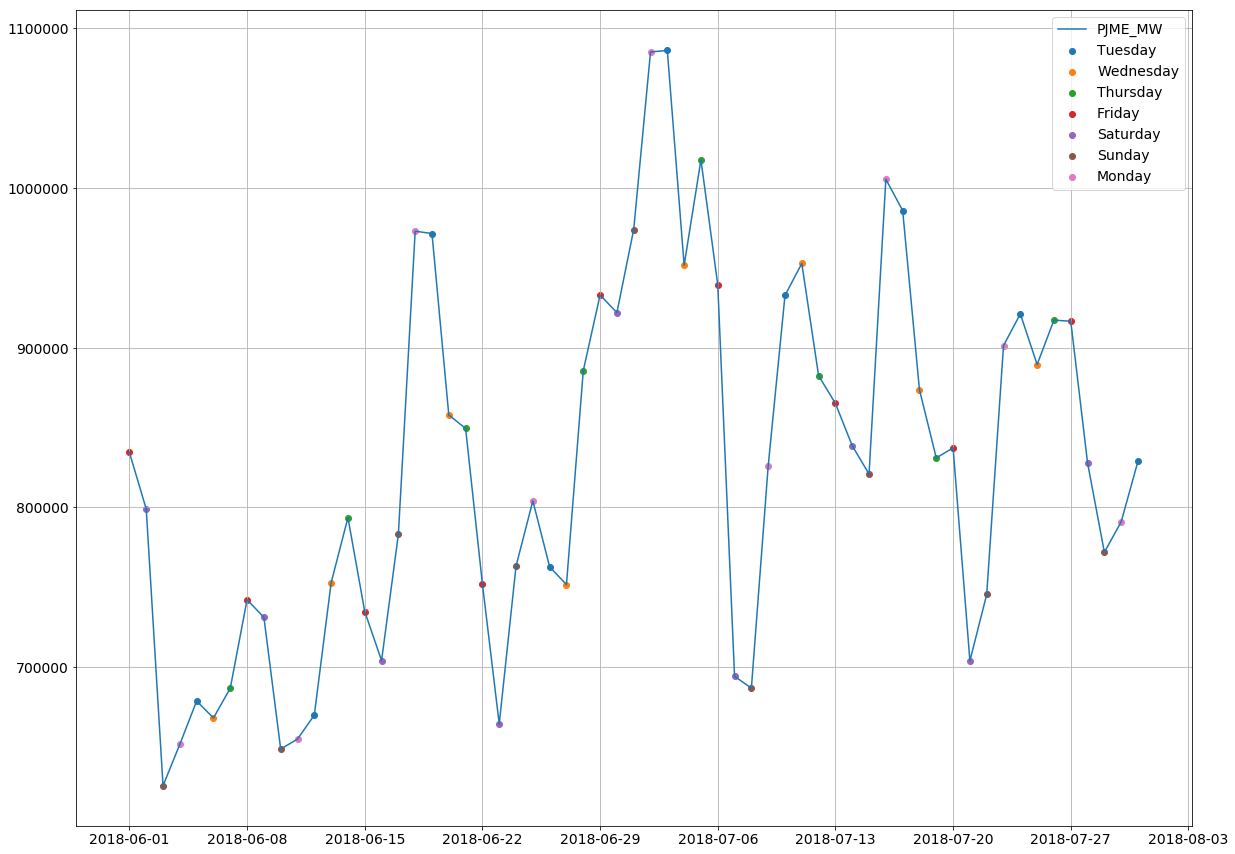

In [30]:
df = energy_consumption.loc['06-01-2018':'07-31-2018'].resample('D')[['PJME_MW']].sum()
_ = plt.plot(df.index, df.PJME_MW)
for D in energy_consumption['Day of Week'].unique():
    df = energy_consumption.loc['06-01-2018':'07-31-2018'].loc[energy_consumption['Day of Week'] == D].copy()
    df = df.resample('D')[['PJME_MW']].sum().copy()
    df = df.loc[df['PJME_MW'] != 0].copy()
    _ = plt.scatter( x = df.index, y = df.PJME_MW, label = D)
plt.grid()
plt.legend()
plt.show()

- peaks dominated by Mondays and Tuesdays
- whereas, troughs are dominated by Saturdays and Sundays

In [31]:
energy_consumption.loc['01-01-2017':'31-12-2017'].resample('Q').sum().sort_values('PJME_MW',ascending=False)

,PJME_MW,Hour
Datetime,,
2017-09-30,73627696.0,25392
2017-03-31,66768754.0,24840
2017-12-31,65425156.0,25392
2017-06-30,62680380.0,25116


- The highest energy consumption Qurter in 2017 was in third Qurter (Summer).

In [32]:
year_quarter_con = energy_consumption.copy()
year_quarter_con['Year'] = year_quarter_con.index.year
year_quarter_con['Quarter'] = year_quarter_con.index.quarter

In [33]:
year_quarter_con = year_quarter_con.groupby(['Year','Quarter'])[['PJME_MW']].sum()
year_quarter_con.iloc[year_quarter_con.reset_index().groupby(['Year'])['PJME_MW'].idxmax()]

,,PJME_MW
Year,Quarter,
2002,3,79108260.0
2003,3,76773824.0
2004,3,76182651.0
2005,3,83771227.0
2006,3,80581425.0
2007,3,80811919.0
2008,3,78821422.0
2009,3,74989501.0
2010,3,81481624.0


In [34]:
energy_consumption['Quarter'] = energy_consumption.index.quarter
energy_consumption['Month'] = energy_consumption.index.month

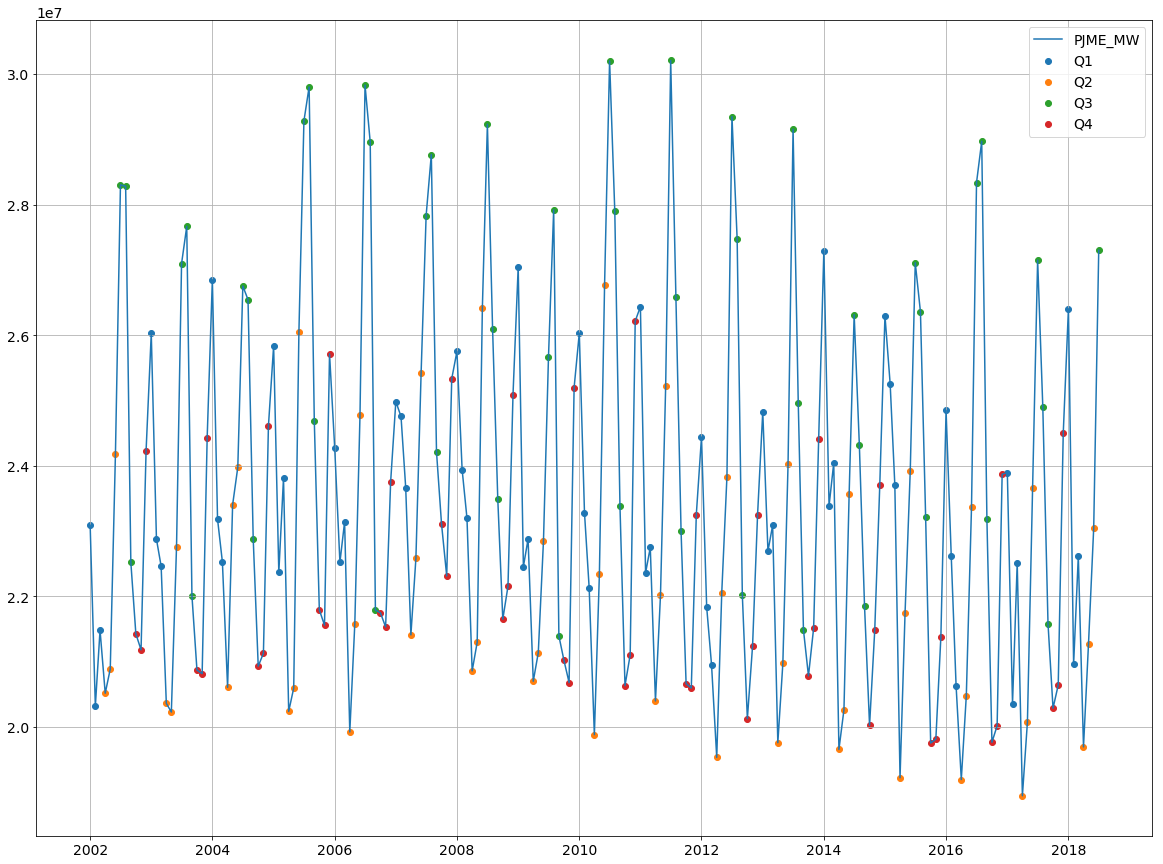

In [35]:
df = energy_consumption.loc[:'31-07-2018'].resample('MS')[['PJME_MW']].sum()
_ = plt.plot( df.index, df.PJME_MW)
for Q in energy_consumption['Quarter'].unique():
    df = energy_consumption.loc[:'31-07-2018'].loc[energy_consumption['Quarter'] == Q].resample('MS')[['PJME_MW']].sum().copy()
    df = df.loc[df['PJME_MW'] != 0].copy()
    _ = plt.scatter( x = df.index, y = df.PJME_MW, label = 'Q' +str(Q))
plt.grid()
plt.legend()
plt.show()

- okay so summer had always been the season with the highest consumption through the years.
- 2nd and 4th quarters had the lowest consumption 

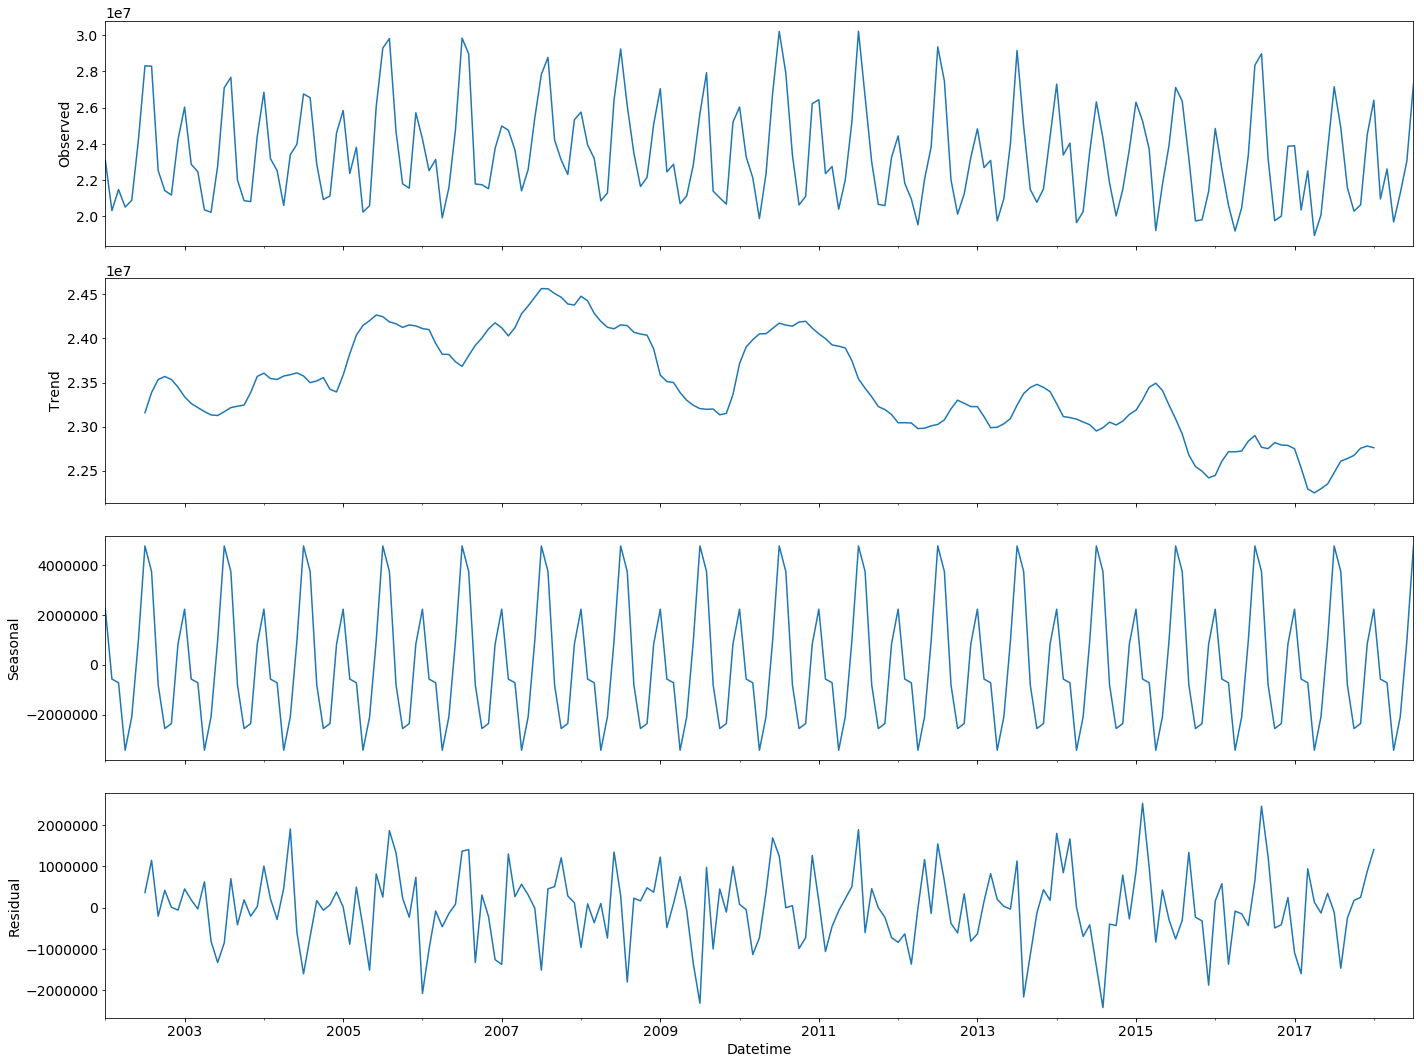

In [36]:
decompose = sm.tsa.seasonal_decompose(energy_consumption.loc[:'31-07-2018'].resample('MS')[['PJME_MW']].sum())
decompose.plot()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015020A59860>]],
      dtype=object)

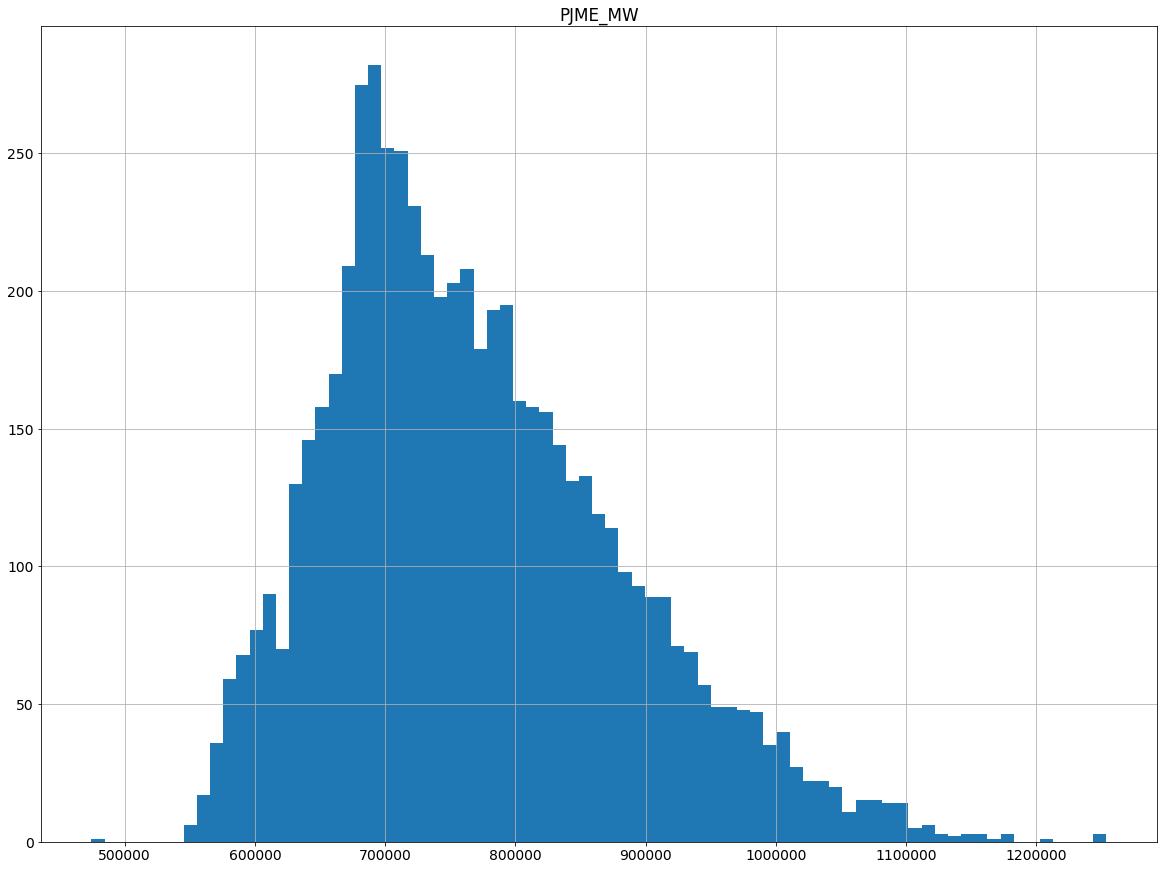

In [37]:
day_consum = energy_consumption.loc[:'31-07-2018'].resample('D')[['PJME_MW']].sum()
day_consum.hist(bins=int(np.sqrt(len(day_consum))))

In [39]:
day_consum.reset_index().to_csv('energy consumption per day.csv',index=False)

In [ ]:
m.plot(forecast);